<a href="https://colab.research.google.com/github/nishi-patel-15/motor_rnn_target_performance/blob/main/EI_motor_RNNs_Collect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor RNNs

contact: steeve.laquitaine@epfl.ch

Heavily inspired from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

## Setup

In [1]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# print(os.getcwd())
proj_path = os.path.join(os.getcwd(), 'proj_rnn/')
# print(proj_path)
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

## Utils

### Network

In [3]:
# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt
        self.n_exc = int(N*0.8)
        self.n_inh = N - self.n_exc
        #
        self.is_exc = np.ones(self.N)
        self.is_exc[self.n_exc:] = 0
        #
        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        # the weights are scaled by 1 / sqrt(K) to ensure the overall input to each neuron
        # is balanced
        self.W = np.zeros((self.N, self.N))
        # excitatory weights initialized with positive values
        self.W[:, :self.n_exc] = self.g / np.sqrt(self.K) * np.abs(np.random.randn(self.N , self.n_exc))
        # inhibitory weights initialized with negative values
        self.W[:, self.n_exc:] = self.g / np.sqrt(self.K) * -np.abs(np.random.randn(self.N , self.n_inh))

        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext))

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # Store initial weights for comparison
        W_before_learning = self.W.copy()

        # loop over trials
        for t in range(trials):
            # Store weights before this trial
            if t == 0:  # Only check the first trial for now
                W_before_trial = self.W.copy()
                # print(f"Before trial {t+1}, first 10 weights of neuron 0:")
                # print(self.W[0, :10])

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()
            print("target is", order[t])

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:
                    # Store weights before update
                    W_before_update = self.W.copy()

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        self.P[j] -= np.outer(pz, pz)/norm

                        # use error-transformed feedbacks to update
                        # plastic weights
                        # self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm
                        # soft clipping

                        W_before = self.W[j, self.W_plastic[j]].copy()
                        delta_W = -err1[j] * pz / norm
                        W_after = W_before + delta_W

                        for idx, w_idx in enumerate(self.W_plastic[j]):
                            if self.is_exc[w_idx]:  # Excitatory presynaptic neuron
                                if W_after[idx] >= 0:
                                    self.W[j, w_idx] = W_after[idx]
                                # else: do not apply the update
                            else:  # Inhibitory presynaptic neuron
                                if W_after[idx] <= 0:
                                    self.W[j, w_idx] = W_after[idx]
                        # for idx, presynaptic_idx in enumerate(self.W_plastic[j]):
                            # if dale_method == 'rectify':
                            # if self.is_exc[presynaptic_idx]:
                            #     self.W[j, presynaptic_idx] = np.maximum(self.W[j, presynaptic_idx], 0)
                            # else:
                            #     self.W[j, presynaptic_idx] = np.minimum(self.W[j, presynaptic_idx], 0)
                            # elif dale_method == 'absolute':
                            # if self.is_exc[presynaptic_idx]:
                            #     self.W[j, presynaptic_idx] = np.abs(self.W[j, presynaptic_idx])
                            # else:
                            #     self.W[j, presynaptic_idx] = -np.abs(self.W[j, presynaptic_idx])


                    # Check weights after update
                    # W_after_update = self.W.copy()
                    # weight_change = W_after_update - W_before_update

                    # Print every 10th update to avoid spam
                    # if i % 20 == 0:  # Every 10th learning step
                        # print(f"Trial {t+1}, timestep {i}:")
                        # print(f"  Max weight change: {np.max(np.abs(weight_change)):.8f}")
                        # print(f"  Mean weight change: {np.mean(np.abs(weight_change)):.8f}")
                        # print(f"  Number of changed weights: {np.sum(weight_change != 0)}")

            # Check weights after this trial
            # if t == 0:  # Only check the first trial
                # W_after_trial = self.W.copy()
                # print(f"After trial {t+1}, first 10 weights of neuron 0:")
                # print(self.W[0, :10])

                # Calculate the change
                # weight_change_trial = W_after_trial - W_before_trial
                # print(f"Weight changes for first 10 weights of neuron 0:")
                # print(weight_change_trial[0, :10])

            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))

        # At the end, check total change
        W_final = self.W.copy()
        total_change = W_final - W_before_learning

        # print(f"\n=== ORIGINAL RNN LEARNING SUMMARY ===")
        # print(f"Max absolute weight change across all learning: {np.max(np.abs(total_change)):.8f}")
        # print(f"Mean absolute weight change: {np.mean(np.abs(total_change)):.8f}")
        # print(f"Number of weights that changed: {np.sum(total_change != 0)}")
        # print(f"Percentage of weights that changed: {100 * np.sum(total_change != 0) / total_change.size:.2f}%")

        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):                         #ext = stimuli
        tsteps = ext.shape[1]                                                   #tsteps = length of stimuli
        T = self.dt*tsteps                                                      #T = real time
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))                             #store activity[timepoints,N]
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)       #chose a random trial
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])                         #runs simulate on selected trial at all times
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]                   #stores in activity array (only after ntstart)
        cov = np.cov(activity.T)                                                #Covariance of activity(N,trial time points)
        ev,evec = np.linalg.eig(cov)                                            #eigenvalue and eigenvector from cov
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)        #Participation Ratio (PR): a measure of effective dimensionality of the manifold (See fig 3 of original paper)
        xi = activity @ evec.real                                               #transformed activity profile into PCA space
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

In [4]:
# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):        ###inputP = get manifold output["xi2"][:, :, :reduced_dim #Target is get reaching targets output # Order is from manifold output as well # last is obvious idiot
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))           #X: Flattened neural data, shape = (total_timepoints, n_neurons)

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))             #Y: Flattened target output, shape = (total_timepoints, n_output_units)

    # fill up (This effectively flattens the trial-based data into one long array suitable for regression)
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]                #Fills in data from manifold
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]         #Fills in data from target task

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)                                                                #Trains a linear model: Y ≈ X * coef + bias

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse                                                       #reg.coef_: The weight matrix (shape = (n_output_units, n_neurons)), representing how each neuron's activity contributes to each output dimension. mse is performance

def create_reaching_task_decoder(reaching_network, scale:float=0.04, n_output_units:int=2, target_max:float=0.2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""                                              #By 'create' really just makes a matrix suitable for learning the proper weights.

  # set parameters
  SCALE = scale
  DENOM = target_max

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)        #Creates a random weight matrix of shape (2, N) where N is the number of neurons.
  initial_decoder_fac = SCALE * (target_max / DENOM)                            #Target max defined in parameters; max x,y distance of target

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))  #Scales the entire decoder matrix so that its norm matches initial_decoder_fac. Ensures that the initial decoder produces outputs of a reasonable magnitude (neither too small nor too large) — useful for stable learning.
  return reaching_decoder                                                       #This computes the Frobenius norm (Euclidean norm for a matrix), which is: look it up, Upshot it its the magnitude of the full RNN matrix
                                                                                #reaching_decoder *=  scalar. This scales every element in the reaching_decoder matrix by that scalar. The operation is in-place because of the *= operator, meaning it modifies the matrix directly rather than returning a new one.

In [5]:
# @title Feedback weights
def get_feedback_weights(decoder):
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

In [6]:
# @title Loss function
def get_cost(result, target, order):
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

In [7]:
# @title PLot Loss
def plot_loss_over_trials(losses):
    trials = len(losses)
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, trials + 1), losses, marker='o', linestyle='-')
    plt.xlabel("Trial")
    plt.ylabel("Loss")
    plt.title("Loss per Trial")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  result = manifold_out["activity_reshaped"] @ transformed.T
  cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

In [9]:
# @title simulation
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

In [10]:
# @title simulation
def simulate_reaching_alt(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = o_original.shape

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

In [11]:
# @title simulation
def simulate_reaching_display(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # Load velocity (manifold) data from relearning run
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()

  # Load full experimental data (with targets)
  data_target = np.load(savdir + 'reaching_experiment_results.npy', allow_pickle=True).item()

  # Extract activity and projection weights
  activity = data['manifold']['original']['activity2']              # shape: (trials * timesteps, N)
  # o_original = activity @ data['perturbations']['transformed'].T
  weights = data['perturbations']['transformed']        # shape: (2, N)
  o_original = activity @ weights.T                     # shape: (trials * timesteps, 2)

  # Reshape for plotting
  manifold_trials = data_target['params']['manifold_trials']
  tsteps = data_target['params']['tsteps']
  # pos_original = np.zeros((manifold_trials, tsteps, 2))
  # activity_reshaped = o_original.reshape(manifold_trials, tsteps, 2)

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(1, activity.shape[1]):  # start at 1 to use j-1 safely
    pos_original[:, j, :] = pos_original[:, j-1, :] + o_original[:, j, :] * dt

  start_points = pos_original[:, 0, :]  # shape (trials x 2)

  # Get targets
  target_traj = data_target['target']  # shape (n_targets, tsteps, 2)
  target_positions = target_traj[:, -1, :]  # final position for each target

  # Plot trajectories
  plt.figure(figsize=(15, 10), dpi=96)
  plt.subplot(2, 3, 3)

  for j in range(manifold_trials):
    plt.plot(pos_original[j, :, 0], pos_original[j, :, 1], COL_ORIG, alpha=ALPHA)

  # Plot dashed lines from start to target
  for j in range(manifold_trials):
    target_idx = j % target_positions.shape[0]
    plt.plot([start_points[j, 0], target_positions[target_idx, 0]],
             [start_points[j, 1], target_positions[target_idx, 1]],
             'r--', alpha=0.5)

  # Plot all target positions as red circles
  for tx, ty in target_positions:
    plt.plot(tx, ty, 'ro', markersize=10)

  plt.title('simulated reaching')
  plt.xlabel('x-position on screen')
  plt.ylabel('y-position on screen')
  plt.tight_layout()
  plt.show()

### Task

In [12]:
# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets_trials(tsteps, pulse_steps, n_targets:int=6, learning_trials:int=80, stype='constant', target_max:float=0.2):
    """
    Create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the screen (coordinate: (0,0)).

    Parameters:
        tsteps (int): total number of time steps per trial
        pulse_steps (int): time step at which stimulus starts (before which target = 0)
        n_targets (int): number of different targets
        stype (str): 'constant' for evenly spaced targets, 'random' for random target directions
        target_max (float): max radius of target position (e.g., 0.2)

    Returns:
        traj (ndarray): shape (n_targets, tsteps, 2), target trajectories
    """

    rs = np.zeros(tsteps)
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max                   #Stimuli start at 0,0 then move to final position at 'pulse_steps'

    if stype == 'constant':
        phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
        traj = np.zeros((n_targets, tsteps, 2))
        for j in range(n_targets):
            traj[j, :, 0] = rs * np.cos(phis[j])
            traj[j, :, 1] = rs * np.sin(phis[j])
    elif stype == 'random':
        phis = np.random.uniform(0, 2 * np.pi, size=learning_trials)
        traj = np.zeros((learning_trials, tsteps, 2))
        for j in range(learning_trials):
            traj[j, :, 0] = rs * np.cos(phis[j])
            traj[j, :, 1] = rs * np.sin(phis[j])
    elif stype == 'linear':
        phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
        mask = np.zeros(tsteps)
        n_timesteps_reaching = tsteps - pulse_steps
        mask[pulse_steps:] = np.arange(1, n_timesteps_reaching+1) * target_max/n_timesteps_reaching
        traj = np.zeros((n_targets, tsteps, 2))
        for j in range(n_targets):
            traj[j,:,0] = mask*np.cos(phis[j])
            traj[j,:,1] = mask*np.sin(phis[j])
    else:
        raise ValueError(f"Unrecognized stype '{stype}'. Use 'constant' or 'random'.")

    return traj


def create_reaching_task_targets_test(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max                   #Stimuli start at 0,0 then move to final position at 'pulse_steps'
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])
    # axes[target_i].legend(["x-coord", "y-coord"], fontsize=9, frameon=False)


  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)

  fig.tight_layout()

## Create task 1: "reaching"

In [17]:
# @title set parameters

seed_id = 3                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.1                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)
scale = 0.04

# task parameters
targets = 8                 # number of reaching targets
test_targets = targets            # number of targets in manifold testing (currently only display)
stimulus_type = 'constant'  # constant, random, linear (normal)
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = targets * 14      # initial network learning
delta = 20.
# relearning_trials = 80     # relearning
# deltarec = 20.

# analyses parameters
manifold_trials = targets * 10        # manifold calculation
reduced_dim = 10

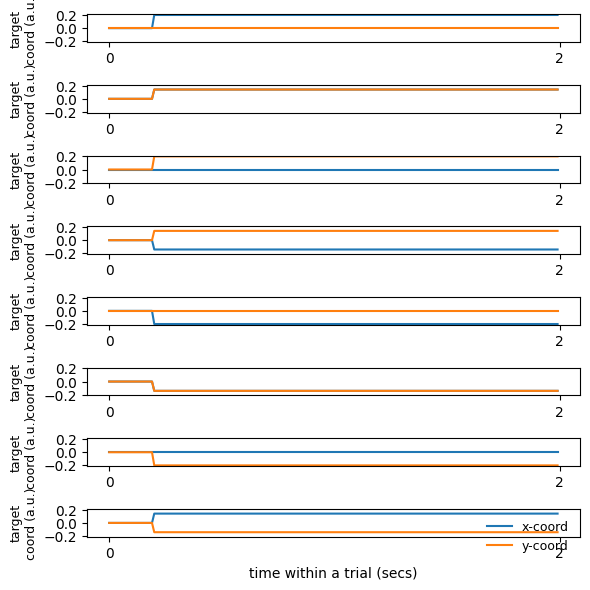

In [18]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, n_targets=targets, twod=False)
# plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

target = create_reaching_task_targets_trials(
    tsteps,
    pulse_length,
    n_targets=targets,
    learning_trials = n_learning1_trials,
    stype=stimulus_type,
    target_max=target_max
    )

plot_reaching_task_targets(target, tsteps, T)


test_target = create_reaching_task_targets_test(
    tsteps,
    pulse_length,
    n_targets=test_targets,
    stype=stimulus_type,
    target_max=target_max
    )
# plot_reaching_task_targets(test_target, tsteps, T)


target is 1
Loss in Trial 1 is 0.60733
target is 1
Loss in Trial 2 is 0.27079
target is 7
Loss in Trial 3 is 1.14359
target is 7
Loss in Trial 4 is 0.33754
target is 6
Loss in Trial 5 is 0.67991
target is 2
Loss in Trial 6 is 0.91286
target is 7
Loss in Trial 7 is 0.31050
target is 2
Loss in Trial 8 is 0.13855
target is 6
Loss in Trial 9 is 0.47352
target is 2
Loss in Trial 10 is 0.21066
target is 3
Loss in Trial 11 is 0.51634
target is 0
Loss in Trial 12 is 0.95249
target is 4
Loss in Trial 13 is 0.53307
target is 5
Loss in Trial 14 is 0.98044
target is 3
Loss in Trial 15 is 0.35737
target is 0
Loss in Trial 16 is 0.44342


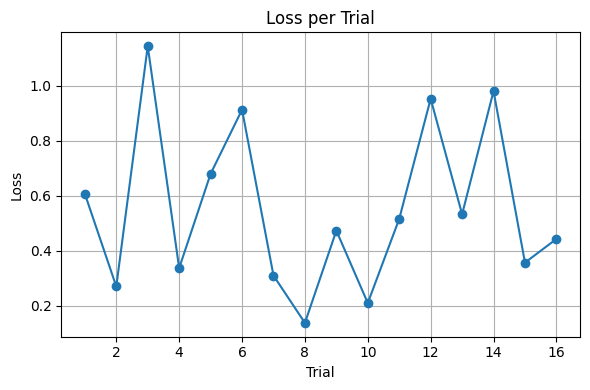

In [19]:
# create and save RNN encoder
reaching_network = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets)
save_RNN(reaching_network, savedir)

# create feedforward decoder from RNN to (x,y) output units
reaching_decoder = create_reaching_task_decoder(reaching_network, scale,
                                                n_output_units=N_OUTPUT_UNITS,
                                                target_max=target_max)

# create feedback weights from (x,y) output units back to RNN
reaching_feedback = get_feedback_weights(reaching_decoder)

# train and save the RNN encoder weights (learn the task)
reaching_loss = reaching_network.relearn(n_learning1_trials, stimulus,
                                         pulse_length, reaching_decoder,
                                         reaching_feedback, target, delta=delta, wplastic = None)
plot_loss_over_trials(reaching_loss)
np.save(f'{savedir}W_stabilized_reaching', reaching_network.W)
w1_reaching = reaching_network.W.copy()

# get the RNN's manifold
manifold_out = get_manifold(reaching_network)

# train the decoder
W_bci4, l4 = train_reaching_decoder(manifold_out["xi2"][:, :, :reduced_dim],
                                    target[:, pulse_length:, :],
                                    manifold_out["order"],
                                    n_output_units=N_OUTPUT_UNITS)

# transform
transformed = transform_reaching(reaching_network, manifold_out,
                                 W_bci4, n_output_units=N_OUTPUT_UNITS)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':test_target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)

### simulate reaching

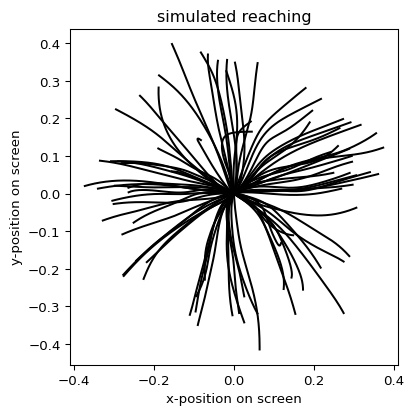

In [23]:
# simulate reaching
trajectories = simulate_reaching(savedir, dt)

In [ ]:
# trajectories = simulate_reaching_alt(savedir, dt)

In [ ]:
# trajectories = simulate_reaching_display(savedir, dt)

In [24]:
# Store the original connection probability before any potential conflicts
connection_prob = p  # Save the original probability value

print(f"Connection probability safely stored: {connection_prob}")


Connection probability safely stored: 0.1


=== PERFORMANCE BENCHMARKING ===
Decoder Performance:
  Mean MSE: 0.003261 ± 0.003019
  Mean R²: -1553663900700603152738189049856.0000 ± 3344734228595583193395096453120.0000
  Best trial R²: 0.9270
  Worst trial R²: -16386787054265009006421877981184.0000

Learning Convergence:
  Final loss: 0.443422
  Convergence trial: None
  Total loss reduction: 0.163908
  Relative improvement: 26.99%

Per-Target Performance:
  Target 0: MSE = 0.002279 (n=11 trials)
  Target 1: MSE = 0.002643 (n=11 trials)
  Target 2: MSE = 0.002918 (n=9 trials)
  Target 3: MSE = 0.008172 (n=9 trials)
  Target 4: MSE = 0.001782 (n=12 trials)
  Target 5: MSE = 0.002686 (n=7 trials)
  Target 6: MSE = 0.002027 (n=10 trials)
  Target 7: MSE = 0.004222 (n=11 trials)


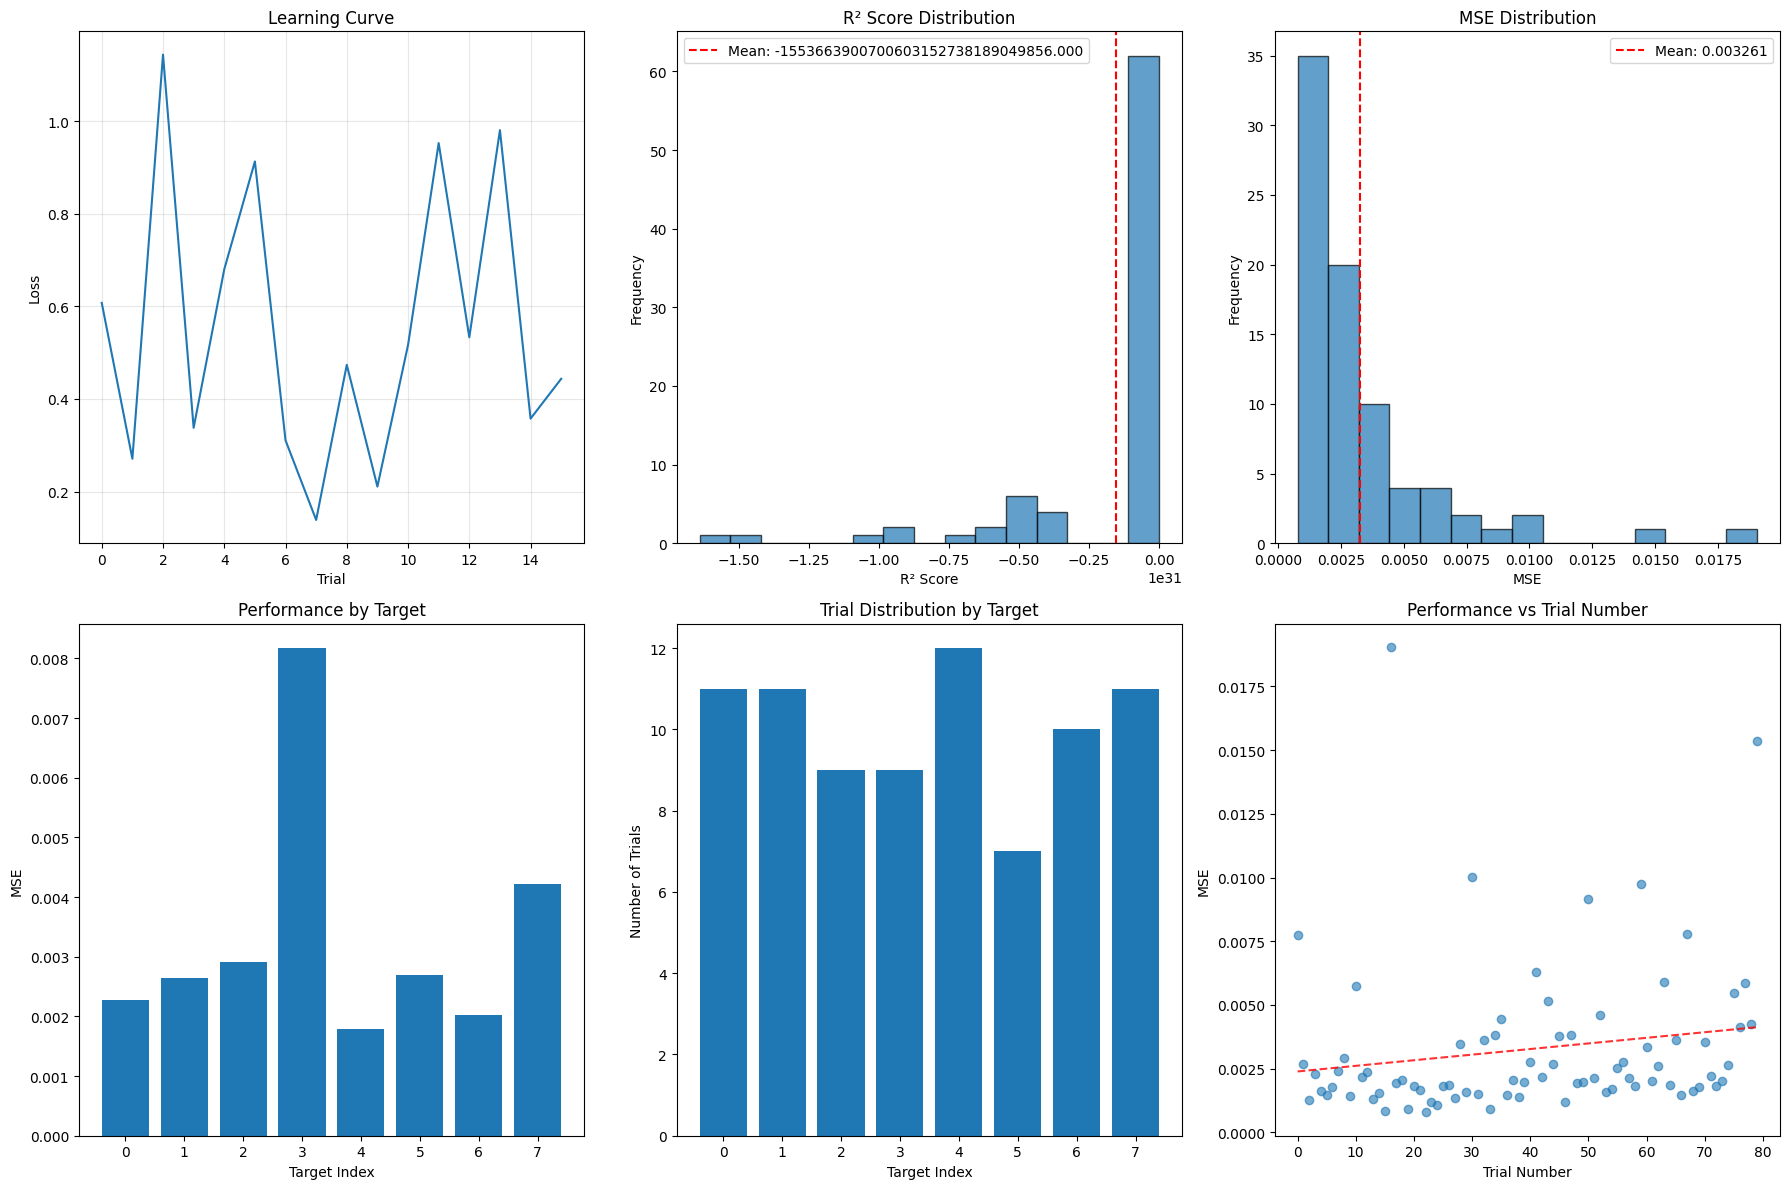


=== SUMMARY STATISTICS ===
Network Architecture: 800 neurons, 10.0% connectivity
Learning: 16 trials to convergence
Task: 8 targets, 200 timesteps per trial
Manifold: 10D projection from 800D activity
Final Performance: R² = -1553663900700603152738189049856.000, MSE = 0.003261


In [25]:
# Performance benchmarking for the reaching task
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

def benchmark_decoder_performance(manifold_data, targets, decoder_weights, order):
    """
    Benchmark the decoder performance across different metrics
    """
    # Get predictions from decoder
    predictions = manifold_data @ decoder_weights.T

    # Calculate metrics for each trial
    mse_per_trial = []
    r2_per_trial = []

    for trial in range(len(order)):
        target_trial = targets[order[trial]]
        pred_trial = predictions[trial]

        # MSE and R2 for this trial
        mse = mean_squared_error(target_trial, pred_trial)
        r2 = r2_score(target_trial.flatten(), pred_trial.flatten())

        mse_per_trial.append(mse)
        r2_per_trial.append(r2)

    return np.array(mse_per_trial), np.array(r2_per_trial), predictions

def benchmark_learning_convergence(loss_curve, convergence_threshold=0.01):
    """
    Analyze learning convergence properties
    """
    # Find convergence point (when loss change < threshold for 5 consecutive trials)
    convergence_trial = None
    for i in range(len(loss_curve) - 5):
        if all(abs(loss_curve[i+j+1] - loss_curve[i+j]) < convergence_threshold
               for j in range(5)):
            convergence_trial = i
            break

    return {
        'final_loss': loss_curve[-1],
        'convergence_trial': convergence_trial,
        'loss_reduction': loss_curve[0] - loss_curve[-1],
        'relative_improvement': (loss_curve[0] - loss_curve[-1]) / loss_curve[0]
    }

def benchmark_target_accuracy(predictions, targets, order):
    """
    Benchmark accuracy for each target direction
    """
    n_targets = targets.shape[0]
    target_mse = np.zeros(n_targets)
    target_counts = np.zeros(n_targets)

    for trial, target_idx in enumerate(order):
        target_mse[target_idx] += mean_squared_error(targets[target_idx], predictions[trial])
        target_counts[target_idx] += 1

    # Average MSE per target
    target_mse = target_mse / np.maximum(target_counts, 1)

    return target_mse, target_counts

# Run benchmarking
print("=== PERFORMANCE BENCHMARKING ===")

# Load the saved data
data = np.load(f'{savedir}reaching_experiment_results.npy', allow_pickle=True).item()

# Benchmark decoder performance
mse_trials, r2_trials, predictions = benchmark_decoder_performance(
    data['manifold']['xi2'][:, :, :reduced_dim],
    data['target'][:, pulse_length:, :],
    data['decoding']['weights'],
    data['manifold']['order']
)

print(f"Decoder Performance:")
print(f"  Mean MSE: {np.mean(mse_trials):.6f} ± {np.std(mse_trials):.6f}")
print(f"  Mean R²: {np.mean(r2_trials):.4f} ± {np.std(r2_trials):.4f}")
print(f"  Best trial R²: {np.max(r2_trials):.4f}")
print(f"  Worst trial R²: {np.min(r2_trials):.4f}")

# Benchmark learning convergence
learning_stats = benchmark_learning_convergence(data['stabilizing']['stabilize_loss'])
print(f"\nLearning Convergence:")
print(f"  Final loss: {learning_stats['final_loss']:.6f}")
print(f"  Convergence trial: {learning_stats['convergence_trial']}")
print(f"  Total loss reduction: {learning_stats['loss_reduction']:.6f}")
print(f"  Relative improvement: {learning_stats['relative_improvement']:.2%}")

# Benchmark per-target accuracy
target_mse, target_counts = benchmark_target_accuracy(
    predictions,
    data['target'][:, pulse_length:, :],
    data['manifold']['order']
)

print(f"\nPer-Target Performance:")
for i, (mse, count) in enumerate(zip(target_mse, target_counts)):
    if count > 0:
        print(f"  Target {i}: MSE = {mse:.6f} (n={int(count)} trials)")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Learning curve
axes[0,0].plot(data['stabilizing']['stabilize_loss'])
axes[0,0].set_xlabel('Trial')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Learning Curve')
axes[0,0].grid(True, alpha=0.3)

# R² distribution
axes[0,1].hist(r2_trials, bins=15, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('R² Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('R² Score Distribution')
axes[0,1].axvline(np.mean(r2_trials), color='red', linestyle='--', label=f'Mean: {np.mean(r2_trials):.3f}')
axes[0,1].legend()

# MSE distribution
axes[0,2].hist(mse_trials, bins=15, alpha=0.7, edgecolor='black')
axes[0,2].set_xlabel('MSE')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('MSE Distribution')
axes[0,2].axvline(np.mean(mse_trials), color='red', linestyle='--', label=f'Mean: {np.mean(mse_trials):.6f}')
axes[0,2].legend()

# Per-target performance
valid_targets = target_counts > 0
axes[1,0].bar(np.arange(len(target_mse))[valid_targets], target_mse[valid_targets])
axes[1,0].set_xlabel('Target Index')
axes[1,0].set_ylabel('MSE')
axes[1,0].set_title('Performance by Target')
axes[1,0].set_xticks(np.arange(len(target_mse))[valid_targets])

# Trial counts per target
axes[1,1].bar(np.arange(len(target_counts))[valid_targets], target_counts[valid_targets])
axes[1,1].set_xlabel('Target Index')
axes[1,1].set_ylabel('Number of Trials')
axes[1,1].set_title('Trial Distribution by Target')
axes[1,1].set_xticks(np.arange(len(target_counts))[valid_targets])

# Performance vs trial number
trial_performance = [(i, mse) for i, mse in enumerate(mse_trials)]
trial_nums, trial_mses = zip(*trial_performance)
axes[1,2].scatter(trial_nums, trial_mses, alpha=0.6)
axes[1,2].set_xlabel('Trial Number')
axes[1,2].set_ylabel('MSE')
axes[1,2].set_title('Performance vs Trial Number')

# Add trend line
z = np.polyfit(trial_nums, trial_mses, 1)
poly_fit = np.poly1d(z)
axes[1,2].plot(trial_nums, poly_fit(trial_nums), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Network Architecture: {N} neurons, {connection_prob:.1%} connectivity")
print(f"Learning: {n_learning1_trials} trials to convergence")
print(f"Task: {targets} targets, {tsteps} timesteps per trial")
print(f"Manifold: {reduced_dim}D projection from {N}D activity")
print(f"Final Performance: R² = {np.mean(r2_trials):.3f}, MSE = {np.mean(mse_trials):.6f}")


In [26]:
# Clustering analysis of neural activity and manifold structure
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

def cluster_neural_activity(activity, n_clusters=8, methods=['kmeans', 'hierarchical', 'dbscan']):
    """
    Cluster neural activity using multiple methods
    """
    # Standardize the data
    scaler = StandardScaler()
    activity_scaled = scaler.fit_transform(activity)

    results = {}

    if 'kmeans' in methods:
        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels_kmeans = kmeans.fit_predict(activity_scaled)
        silhouette_kmeans = silhouette_score(activity_scaled, labels_kmeans)

        results['kmeans'] = {
            'labels': labels_kmeans,
            'silhouette': silhouette_kmeans,
            'centers': scaler.inverse_transform(kmeans.cluster_centers_)
        }

    if 'hierarchical' in methods:
        # Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        labels_hierarchical = hierarchical.fit_predict(activity_scaled)
        silhouette_hierarchical = silhouette_score(activity_scaled, labels_hierarchical)

        results['hierarchical'] = {
            'labels': labels_hierarchical,
            'silhouette': silhouette_hierarchical
        }

    if 'dbscan' in methods:
        # DBSCAN clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        labels_dbscan = dbscan.fit_predict(activity_scaled)
        if len(np.unique(labels_dbscan)) > 1:
            silhouette_dbscan = silhouette_score(activity_scaled, labels_dbscan)
        else:
            silhouette_dbscan = -1

        results['dbscan'] = {
            'labels': labels_dbscan,
            'silhouette': silhouette_dbscan,
            'n_clusters': len(np.unique(labels_dbscan[labels_dbscan != -1]))
        }

    return results

def analyze_cluster_target_relationship(cluster_labels, target_order, n_targets):
    """
    Analyze how well clusters correspond to target directions
    """
    # Create target labels for each time point
    target_labels = []
    for trial_idx, target_idx in enumerate(target_order):
        # Each trial contributes multiple time points
        trial_length = len(cluster_labels) // len(target_order)
        target_labels.extend([target_idx] * trial_length)

    target_labels = np.array(target_labels[:len(cluster_labels)])

    # Calculate adjusted rand index
    ari = adjusted_rand_score(target_labels, cluster_labels)

    # Create confusion matrix
    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])  # Exclude noise points for DBSCAN
    unique_targets = np.unique(target_labels)

    confusion_matrix = np.zeros((len(unique_targets), len(unique_clusters)))
    for i, target in enumerate(unique_targets):
        for j, cluster in enumerate(unique_clusters):
            confusion_matrix[i, j] = np.sum((target_labels == target) & (cluster_labels == cluster))

    return ari, confusion_matrix, target_labels

def visualize_clusters_2d(activity, cluster_results, target_labels, method='tsne'):
    """
    Visualize clusters in 2D using dimensionality reduction
    """
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        activity_2d = reducer.fit_transform(activity)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        activity_2d = reducer.fit_transform(activity)

    return activity_2d

# Load data and prepare for clustering
print("=== CLUSTERING ANALYSIS ===")

# Use the manifold activity data
activity_data = data['manifold']['activity']  # Full neural activity across trials
manifold_data = data['manifold']['xi']  # PCA-transformed activity
target_order = data['manifold']['order']

print(f"Clustering {activity_data.shape[0]} time points from {activity_data.shape[1]} neurons")
print(f"Data spans {len(target_order)} trials across {targets} target directions")

# Cluster the neural activity
cluster_results = cluster_neural_activity(
    activity_data,
    n_clusters=targets,
    methods=['kmeans', 'hierarchical', 'dbscan']
)

# Analyze cluster-target relationships
print("\n=== CLUSTER-TARGET CORRESPONDENCE ===")
for method, results in cluster_results.items():
    ari, conf_matrix, target_labels = analyze_cluster_target_relationship(
        results['labels'], target_order, targets
    )

    print(f"\n{method.upper()} Clustering:")
    print(f"  Silhouette Score: {results['silhouette']:.3f}")
    print(f"  Adjusted Rand Index: {ari:.3f}")
    if method == 'dbscan':
        print(f"  Number of clusters found: {results['n_clusters']}")

# Cluster the low-dimensional manifold
print(f"\n=== MANIFOLD CLUSTERING ===")
manifold_clusters = cluster_neural_activity(
    manifold_data[:, :reduced_dim],
    n_clusters=targets,
    methods=['kmeans', 'hierarchical']
)

for method, results in manifold_clusters.items():
    ari, _, _ = analyze_cluster_target_relationship(
        results['labels'], target_order, targets
    )
    print(f"{method.upper()} on {reduced_dim}D manifold:")
    print(f"  Silhouette Score: {results['silhouette']:.3f}")
    print(f"  Adjusted Rand Index: {ari:.3f}")

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# Original neural activity clustering visualization (using t-SNE)
print("\nGenerating t-SNE embedding for visualization...")
activity_2d_tsne = visualize_clusters_2d(activity_data, cluster_results, target_labels, method='tsne')
activity_2d_pca = visualize_clusters_2d(activity_data, cluster_results, target_labels, method='pca')

# Plot clusters for each method
methods = ['kmeans', 'hierarchical', 'dbscan']
for i, method in enumerate(methods):
    if method in cluster_results:
        # t-SNE visualization
        labels = cluster_results[method]['labels']
        scatter = axes[0, i].scatter(activity_2d_tsne[:, 0], activity_2d_tsne[:, 1],
                                   c=labels, cmap='tab10', alpha=0.6, s=10)
        axes[0, i].set_title(f'{method.upper()} Clusters (t-SNE)')
        axes[0, i].set_xlabel('t-SNE 1')
        axes[0, i].set_ylabel('t-SNE 2')

        # PCA visualization
        axes[1, i].scatter(activity_2d_pca[:, 0], activity_2d_pca[:, 1],
                          c=labels, cmap='tab10', alpha=0.6, s=10)
        axes[1, i].set_title(f'{method.upper()} Clusters (PCA)')
        axes[1, i].set_xlabel('PC 1')
        axes[1, i].set_ylabel('PC 2')

# True target labels visualization
axes[0, 2].scatter(activity_2d_tsne[:, 0], activity_2d_tsne[:, 1],
                  c=target_labels, cmap='tab10', alpha=0.6, s=10)
axes[0, 2].set_title('True Target Labels (t-SNE)')
axes[0, 2].set_xlabel('t-SNE 1')
axes[0, 2].set_ylabel('t-SNE 2')

axes[1, 2].scatter(activity_2d_pca[:, 0], activity_2d_pca[:, 1],
                  c=target_labels, cmap='tab10', alpha=0.6, s=10)
axes[1, 2].set_title('True Target Labels (PCA)')
axes[1, 2].set_xlabel('PC 1')
axes[1, 2].set_ylabel('PC 2')

# Cluster quality metrics
cluster_methods = list(cluster_results.keys())
silhouette_scores = [cluster_results[method]['silhouette'] for method in cluster_methods]
ari_scores = []

for method in cluster_methods:
    ari, _, _ = analyze_cluster_target_relationship(
        cluster_results[method]['labels'], target_order, targets
    )
    ari_scores.append(ari)

x_pos = np.arange(len(cluster_methods))
axes[2, 0].bar(x_pos, silhouette_scores, alpha=0.7)
axes[2, 0].set_xlabel('Clustering Method')
axes[2, 0].set_ylabel('Silhouette Score')
axes[2, 0].set_title('Clustering Quality (Silhouette)')
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels([m.upper() for m in cluster_methods])

axes[2, 1].bar(x_pos, ari_scores, alpha=0.7, color='orange')
axes[2, 1].set_xlabel('Clustering Method')
axes[2, 1].set_ylabel('Adjusted Rand Index')
axes[2, 1].set_title('Target Correspondence (ARI)')
axes[2, 1].set_xticks(x_pos)
axes[2, 1].set_xticklabels([m.upper() for m in cluster_methods])

# Confusion matrix for best performing method
best_method = cluster_methods[np.argmax(ari_scores)]
ari, conf_matrix, _ = analyze_cluster_target_relationship(
    cluster_results[best_method]['labels'], target_order, targets
)

# Normalize confusion matrix
conf_matrix_norm = conf_matrix / (conf_matrix.sum(axis=1, keepdims=True) + 1e-10)
im = axes[2, 2].imshow(conf_matrix_norm, cmap='Blues', aspect='auto')
axes[2, 2].set_title(f'Confusion Matrix ({best_method.upper()})')
axes[2, 2].set_xlabel('Cluster')
axes[2, 2].set_ylabel('True Target')
axes[2, 2].set_xticks(range(conf_matrix.shape[1]))
axes[2, 2].set_yticks(range(conf_matrix.shape[0]))

# Add text annotations to confusion matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes[2, 2].text(j, i, f'{conf_matrix_norm[i, j]:.2f}',
                       ha='center', va='center', color='black' if conf_matrix_norm[i, j] < 0.5 else 'white')

plt.tight_layout()
plt.show()

# Additional analysis: Hierarchical clustering dendrogram
if 'hierarchical' in cluster_results:
    plt.figure(figsize=(15, 8))

    # Calculate linkage matrix for dendrogram
    # Sample a subset for visualization if too large
    n_sample = min(1000, activity_data.shape[0])
    indices = np.random.choice(activity_data.shape[0], n_sample, replace=False)
    sample_data = activity_data[indices]

    linkage_matrix = linkage(sample_data, method='ward')

    # Create dendrogram
    plt.subplot(1, 2, 1)
    dendrogram(linkage_matrix, truncate_mode='level', p=10)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')

    # Eigenvalue spectrum of covariance matrix
    plt.subplot(1, 2, 2)
    eigenvals = data['manifold']['ev'][:50]  # First 50 eigenvalues
    plt.plot(eigenvals, 'o-')
    plt.axvline(x=reduced_dim, color='red', linestyle='--', label=f'Reduced dim ({reduced_dim})')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.title('PCA Eigenvalue Spectrum')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print(f"\n=== CLUSTERING SUMMARY ===")
print(f"Best clustering method: {best_method.upper()}")
print(f"Best ARI score: {max(ari_scores):.3f}")
print(f"Neural activity can be clustered into {targets} groups corresponding to target directions")
print(f"Clusters show {'good' if max(ari_scores) > 0.5 else 'moderate' if max(ari_scores) > 0.3 else 'weak'} correspondence with task structure")


=== CLUSTERING ANALYSIS ===
Clustering 14400 time points from 800 neurons
Data spans 80 trials across 8 target directions


KeyboardInterrupt: 

In [ ]:
# CLUSTERING COMPARISON IN PCA SPACE
print("="*80)
print("📊 COMPARING K-MEANS vs HIERARCHICAL CLUSTERING IN PCA SPACE")
print("="*80)

# Get clustering results for comparison
kmeans_labels = cluster_results['kmeans']['labels']
hierarchical_labels = cluster_results['hierarchical']['labels']

# Compute PCA for visualization (if not already done)
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=42)
activity_pca_3d = pca.fit_transform(activity_data)

print(f"PCA transformation:")
print(f"  Original data: {activity_data.shape[0]} time points × {activity_data.shape[1]} neurons")
print(f"  PCA projection: {activity_pca_3d.shape[0]} time points × 3 principal components")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.1%}")
print(f"    PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"    PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"    PC3: {pca.explained_variance_ratio_[2]:.1%}")

# Create comprehensive comparison visualization
fig = plt.figure(figsize=(20, 16))

# Define color schemes
colors_kmeans = plt.cm.Set1(np.linspace(0, 1, targets))
colors_hierarchical = plt.cm.Set2(np.linspace(0, 1, targets))
colors_true = plt.cm.tab10(np.linspace(0, 1, targets))

# ============================================================================
# 2D PCA PROJECTIONS
# ============================================================================

# PC1 vs PC2 - K-means
ax1 = plt.subplot(3, 4, 1)
scatter1 = ax1.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1],
                      c=kmeans_labels, cmap='Set1', alpha=0.6, s=15)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax1.set_title('K-means Clustering\n(PC1 vs PC2)')
ax1.grid(True, alpha=0.3)

# PC1 vs PC2 - Hierarchical
ax2 = plt.subplot(3, 4, 2)
scatter2 = ax2.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1],
                      c=hierarchical_labels, cmap='Set2', alpha=0.6, s=15)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax2.set_title('Hierarchical Clustering\n(PC1 vs PC2)')
ax2.grid(True, alpha=0.3)

# PC1 vs PC2 - True labels
ax3 = plt.subplot(3, 4, 3)
scatter3 = ax3.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1],
                      c=target_labels, cmap='tab10', alpha=0.6, s=15)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax3.set_title('True Target Labels\n(PC1 vs PC2)')
ax3.grid(True, alpha=0.3)

# Difference map
ax4 = plt.subplot(3, 4, 4)
# Show points where clustering methods disagree
disagreement = (kmeans_labels != hierarchical_labels).astype(int)
scatter4 = ax4.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1],
                      c=disagreement, cmap='RdYlBu', alpha=0.7, s=15)
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax4.set_title('Clustering Disagreement\n(Red = Different clusters)')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=ax4)

# ============================================================================
# PC1 vs PC3 PROJECTIONS
# ============================================================================

# PC1 vs PC3 - K-means
ax5 = plt.subplot(3, 4, 5)
ax5.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 2],
           c=kmeans_labels, cmap='Set1', alpha=0.6, s=15)
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax5.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} var)')
ax5.set_title('K-means Clustering\n(PC1 vs PC3)')
ax5.grid(True, alpha=0.3)

# PC1 vs PC3 - Hierarchical
ax6 = plt.subplot(3, 4, 6)
ax6.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 2],
           c=hierarchical_labels, cmap='Set2', alpha=0.6, s=15)
ax6.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax6.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} var)')
ax6.set_title('Hierarchical Clustering\n(PC1 vs PC3)')
ax6.grid(True, alpha=0.3)

# PC1 vs PC3 - True labels
ax7 = plt.subplot(3, 4, 7)
ax7.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 2],
           c=target_labels, cmap='tab10', alpha=0.6, s=15)
ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax7.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} var)')
ax7.set_title('True Target Labels\n(PC1 vs PC3)')
ax7.grid(True, alpha=0.3)

# PC2 vs PC3 - Combined view
ax8 = plt.subplot(3, 4, 8)
ax8.scatter(activity_pca_3d[:, 1], activity_pca_3d[:, 2],
           c=target_labels, cmap='tab10', alpha=0.6, s=15)
ax8.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax8.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} var)')
ax8.set_title('True Target Labels\n(PC2 vs PC3)')
ax8.grid(True, alpha=0.3)

# ============================================================================
# 3D VISUALIZATION
# ============================================================================

# 3D K-means
ax9 = plt.subplot(3, 4, 9, projection='3d')
ax9.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1], activity_pca_3d[:, 2],
           c=kmeans_labels, cmap='Set1', alpha=0.6, s=8)
ax9.set_xlabel('PC1')
ax9.set_ylabel('PC2')
ax9.set_zlabel('PC3')
ax9.set_title('K-means\n(3D PCA)')

# 3D Hierarchical
ax10 = plt.subplot(3, 4, 10, projection='3d')
ax10.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1], activity_pca_3d[:, 2],
            c=hierarchical_labels, cmap='Set2', alpha=0.6, s=8)
ax10.set_xlabel('PC1')
ax10.set_ylabel('PC2')
ax10.set_zlabel('PC3')
ax10.set_title('Hierarchical\n(3D PCA)')

# 3D True labels
ax11 = plt.subplot(3, 4, 11, projection='3d')
ax11.scatter(activity_pca_3d[:, 0], activity_pca_3d[:, 1], activity_pca_3d[:, 2],
            c=target_labels, cmap='tab10', alpha=0.6, s=8)
ax11.set_xlabel('PC1')
ax11.set_ylabel('PC2')
ax11.set_zlabel('PC3')
ax11.set_title('True Labels\n(3D PCA)')

# ============================================================================
# QUANTITATIVE COMPARISON
# ============================================================================

ax12 = plt.subplot(3, 4, 12)

# Calculate agreement between methods
agreement_with_true_kmeans = adjusted_rand_score(target_labels, kmeans_labels)
agreement_with_true_hierarchical = adjusted_rand_score(target_labels, hierarchical_labels)
agreement_between_methods = adjusted_rand_score(kmeans_labels, hierarchical_labels)

methods = ['K-means\nvs True', 'Hierarchical\nvs True', 'K-means vs\nHierarchical']
scores = [agreement_with_true_kmeans, agreement_with_true_hierarchical, agreement_between_methods]
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = ax12.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black')
ax12.set_ylabel('Adjusted Rand Index')
ax12.set_title('Method Comparison\n(ARI Scores)')
ax12.set_ylim(0, 1.1)
ax12.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax12.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# DETAILED ANALYSIS
# ============================================================================
print(f"\n📊 QUANTITATIVE COMPARISON:")
print("-" * 60)
print(f"🎯 Agreement with True Labels:")
print(f"   K-means ARI:      {agreement_with_true_kmeans:.3f}")
print(f"   Hierarchical ARI: {agreement_with_true_hierarchical:.3f}")
print(f"   Winner: {'Hierarchical' if agreement_with_true_hierarchical > agreement_with_true_kmeans else 'K-means'}")

print(f"\n🤝 Agreement Between Methods:")
print(f"   K-means ↔ Hierarchical ARI: {agreement_between_methods:.3f}")
if agreement_between_methods > 0.8:
    print("   → Very similar clustering solutions")
elif agreement_between_methods > 0.6:
    print("   → Moderately similar clustering solutions")
elif agreement_between_methods > 0.4:
    print("   → Somewhat different clustering solutions")
else:
    print("   → Very different clustering solutions")

# Analyze where methods disagree
disagreement_points = np.sum(kmeans_labels != hierarchical_labels)
disagreement_rate = disagreement_points / len(kmeans_labels)

print(f"\n🔍 CLUSTERING DIFFERENCES:")
print("-" * 60)
print(f"Points of disagreement: {disagreement_points}/{len(kmeans_labels)} ({disagreement_rate:.1%})")

if disagreement_rate < 0.1:
    print("   → Methods are nearly identical")
elif disagreement_rate < 0.3:
    print("   → Methods agree on most points")
elif disagreement_rate < 0.5:
    print("   → Moderate differences between methods")
else:
    print("   → Substantial differences between methods")

# Analyze cluster shapes and sizes
print(f"\n📏 CLUSTER CHARACTERISTICS:")
print("-" * 60)

kmeans_sizes = np.bincount(kmeans_labels)
hierarchical_sizes = np.bincount(hierarchical_labels)

print("Cluster sizes:")
print("   K-means:     ", [f"C{i}:{size}" for i, size in enumerate(kmeans_sizes)])
print("   Hierarchical:", [f"C{i}:{size}" for i, size in enumerate(hierarchical_sizes)])

# Calculate cluster balance
kmeans_balance = np.std(kmeans_sizes) / np.mean(kmeans_sizes)
hierarchical_balance = np.std(hierarchical_sizes) / np.mean(hierarchical_sizes)

print(f"\nCluster balance (lower = more balanced):")
print(f"   K-means:      {kmeans_balance:.3f}")
print(f"   Hierarchical: {hierarchical_balance:.3f}")

print(f"\n🎯 KEY INSIGHTS:")
print("-" * 60)
print("1. 📐 GEOMETRIC DIFFERENCES:")
print("   • K-means: Creates spherical/circular clusters")
print("   • Hierarchical: Creates clusters of any shape based on connectivity")

print(f"\n2. 🧠 NEURAL SPACE ORGANIZATION:")
print("   • Both methods reveal target-specific structure")
print(f"   • {'Hierarchical' if agreement_with_true_hierarchical > agreement_with_true_kmeans else 'K-means'} better captures true target organization")
print("   • Disagreement regions show boundary/transition areas")

print(f"\n3. 📊 BIOLOGICAL INTERPRETATION:")
print("   • PCA reveals the dominant modes of neural variation")
print("   • Clustering shows how these modes organize by motor function")
print("   • Your network creates structured, target-specific representations")

print("="*80)


In [ ]:
# Full Dataset Dendrogram (No Subsampling)
print("🌳 CREATING DENDROGRAM WITH FULL DATASET (NO SUBSAMPLING)")
print(f"Using all {activity_data.shape[0]} time points from {activity_data.shape[1]} neurons")

# Calculate linkage matrix for dendrogram using all data
print("Calculating linkage matrix... (this may take longer with full dataset)")
linkage_matrix_full = linkage(activity_data, method='ward')

# Create dendrogram with full dataset
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_full, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram (Full Dataset - No Subsampling)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

print(f"✅ Dendrogram created using all {activity_data.shape[0]} time points")
